# Import stocks price data from Finnhub


In [1]:
import finnhub
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Setup client with my personal api_key (see https://finnhub.io/)
finnhub_client = finnhub.Client(api_key="your_api_key")

# Data from saturday 1 January 1990 00:00:00 = 628387200 UNIX timestamp
#      to   wednesday 27 July 2022 06:43:50  = 1658904230 UNIX timestamp
data = finnhub_client.stock_candles('AAPL', 'D', 628387200, 1658904230) 
# Convert to Pandas Dataframe
data = pd.DataFrame(data)
# Rename columns
data = data.rename(columns={"c": "close", "h": "high", "l": "low", "o": "open", "s": "status", "t": "date", "v": "volume"})

print("Shape of data", data.shape)
data.head()

Shape of data (8227, 7)


,close,high,low,open,status,date,volume
0,0.39509,0.39732,0.38839,0.39062,ok,628387200,63448000
1,0.39286,0.40179,0.38951,0.39732,ok,628473600,146227312
2,0.40402,0.40625,0.39062,0.39062,ok,628732800,97361600
3,0.40179,0.40848,0.39732,0.40402,ok,628819200,121766512
4,0.38170,0.40402,0.36607,0.40179,ok,628905600,334869024


In [2]:
# Remove rows with status no_data
data = data[data['status'] == 'ok']
# Remove status column
data = data.drop(['status'], axis='columns')
# Convert UNIX timestamp to date 
#     For form y-m-d -h-m-mil -> datetime.datetime.fromtimestamp
#     For form y-m-d -> datetime.date.fromtimestamp 
data['date'] = data['date'].apply(datetime.date.fromtimestamp, 'columns') 
# Convert to datetime pandas
data['date'] = pd.to_datetime(data['date'])
# set index datetime
data = data.set_index('date')

data.head()

,close,high,low,open,volume
date,,,,,
1989-11-30,0.39509,0.39732,0.38839,0.39062,63448000
1989-12-01,0.39286,0.40179,0.38951,0.39732,146227312
1989-12-04,0.40402,0.40625,0.39062,0.39062,97361600
1989-12-05,0.40179,0.40848,0.39732,0.40402,121766512
1989-12-06,0.38170,0.40402,0.36607,0.40179,334869024


# Donchian Channel Breakout Trading Strategy

The idea is to buy when new highs are broken and sell when new lows are violated.  
This strategy works if there is momentum following impulsive movements.  
(Inertia: In physics, it is the tendency of a body to maintain its current state.)

To capture breakouts of levels, we could use volatility bands such as:

- Bollinger Bands
- Donchian Channel (also known as HHV, Highest High Value, and LLV, Lowest Low Value)

Specifically:

- **Bollinger Band Upper**: Average closing prices + 2 × standard deviation of closing prices.
- **Bollinger Band Lower**: Average closing prices – 2 × standard deviation of closing prices.
- **Donchian Channel High (HHV)**: The highest of the last N highs.
- **Donchian Channel Low (LLV)**: The lowest of the last N lows.

The key difference between these two classes of indicators lies in the fact that the former considers volatility (standard deviation), while the latter is based solely on price levels.


In [3]:
# Adding features
data["dayofweek"] = data.index.dayofweek
data["day"] = data.index.day
data["month"] = data.index.month
data["year"] = data.index.year
data["dayofyear"] = data.index.dayofyear
data["quarter"] = data.index.quarter

data.head()

,close,high,low,open,volume,dayofweek,day,month,year,dayofyear,quarter
date,,,,,,,,,,,
1989-11-30,0.39509,0.39732,0.38839,0.39062,63448000,3,30,11,1989,334,4
1989-12-01,0.39286,0.40179,0.38951,0.39732,146227312,4,1,12,1989,335,4
1989-12-04,0.40402,0.40625,0.39062,0.39062,97361600,0,4,12,1989,338,4
1989-12-05,0.40179,0.40848,0.39732,0.40402,121766512,1,5,12,1989,339,4
1989-12-06,0.38170,0.40402,0.36607,0.40179,334869024,2,6,12,1989,340,4


In [4]:
# Donchian Channel calculation at 5 and 20 rolling time
data["hhv20"] = data.high.rolling(20).max() # maximum of the last 20 values (including current value)
data["llv20"] = data.low.rolling(20).min() # minimum of the last 20 values (including current value)
data["hhv5"] = data.high.rolling(5).max() # maximum of the last 5 values (including current value)
data["llv5"] = data.low.rolling(5).min() # minimum of the last 5 values (including current value)
data.dropna(inplace=True)

# save to csv
file_name = "./Data_AAPL/dataAAPL.csv"
data.to_csv(file_name, index=True)

data.head()

,close,high,low,open,volume,dayofweek,day,month,year,dayofyear,quarter,hhv20,llv20,hhv5,llv5
date,,,,,,,,,,,,,,,
1989-12-28,0.30915,0.31473,0.30580,0.31250,151256112,3,28,12,1989,362,4,0.40848,0.29018,0.33259,0.3058
1989-12-29,0.31473,0.31920,0.30692,0.31027,152409712,4,29,12,1989,363,4,0.40848,0.29018,0.33259,0.3058
1990-01-02,0.33259,0.33482,0.31250,0.31473,183198512,1,2,1,1990,2,1,0.40848,0.29018,0.33482,0.3058
1990-01-03,0.33482,0.33929,0.33482,0.33929,207995312,2,3,1,1990,3,1,0.40848,0.29018,0.33929,0.3058
1990-01-04,0.33594,0.34598,0.33259,0.34152,221513712,3,4,1,1990,4,1,0.40402,0.29018,0.34598,0.3058


Now we proceed with creating the trading system and its support functions.

In [5]:
# True when:
# array1 crosses array2 from below to above
def crossover(array1, array2):
    return (array1 > array2) & (array1.shift(1) < array2.shift(1))

# True when:
# array1 crosses array2 from above to below
def crossunder(array1, array2):
    return (array1 < array2) & (array1.shift(1) > array2.shift(1))

# When the daily close crosses the 20-period Donchian Channel High (hhv20),
# we will buy a number of Apple shares
enter_rules = crossover(data.close, data.hhv20.shift(1)) # 20 periods = approximately one month on the stock market
exit_rules = crossunder(data.close, data.llv5.shift(1)) | (data.day < data.day.shift(1)) # 5 periods = one stock market week

print("Exit rules: \n", exit_rules.head())
print("")
print("Enter rules: \n", enter_rules.tail())

Exit rules: 
 date
1989-12-28    False
1989-12-29    False
1990-01-02     True
1990-01-03    False
1990-01-04    False
dtype: bool

Enter rules: 
 date
2022-07-21    False
2022-07-22    False
2022-07-25    False
2022-07-26    False
2022-07-27     True
dtype: bool


In [6]:
def marketposition_generator(service_dataframe, enter_rules, exit_rules):    
    # mp = market position, equals 1 when trading, 0 otherwise
    # status=1 trading status
    # status=0 otherwise
    status = 0 
    mp = [] # list of market positions
    for (i, j) in zip(enter_rules, exit_rules):
        if status == 0:  # BUY RULE 
            if (i == 1 and j != -1):
                status = 1
        else:           # SELL RULE
            if j == -1 :
                status = 0
                
        mp.append(status)
    
    service_dataframe['mp'] = mp
    service_dataframe['mp_not_shifted'] = mp
    # Delay by one record as the operation will atually start the next bar
    service_dataframe.mp = service_dataframe.mp.shift(1) 
    return service_dataframe

In [7]:
def apply_trading_system(imported_dataframe, enter_rules, exit_rules):
    
    dataframe = imported_dataframe.copy()
    dataframe['enter_rules'] = enter_rules.apply(lambda x: 1 if x == True else 0)
    dataframe['exit_rules'] = exit_rules.apply(lambda x: -1 if x == True else 0)
    # make market positions status (mp)
    dataframe = marketposition_generator(dataframe, dataframe.enter_rules, dataframe.exit_rules)
    # entry price 
    dataframe["entry_price"] = np.where((dataframe.mp.shift(1) == 0) & 
                                        (dataframe.mp == 1), dataframe.open, np.nan)
    # number of stokes purchased
    dataframe["number_of_stocks"] = np.where((dataframe.mp.shift(1) == 0) & 
                                        (dataframe.mp == 1), OPERATION_MONEY / dataframe.open, np.nan) 
    # fill with entry price
    # ffill=forward-fill propagates the last observed non-null value forward until another non-null value is encountered
    dataframe["entry_price"] = dataframe["entry_price"].fillna(method='ffill')
    # round number of stockes purchased
    dataframe["number_of_stocks"] = dataframe["number_of_stocks"]\
                                        .apply(lambda x: round(x,0)).fillna(method='ffill')    
    # open operations=instant trade gain / loss (when mp=1),
    #                 0 otherwise               (when mp=0)
    dataframe["open_operations"] = (dataframe.close - dataframe.entry_price) * dataframe.number_of_stocks
    # At the exit of the trade: total gain/loss * number of stokes - transaction costs
    dataframe["open_operations"] = np.where((dataframe.mp == 1) & (dataframe.mp.shift(-1) == 0), 
            (dataframe.open.shift(-1) - dataframe.entry_price) * dataframe.number_of_stocks - 2 * COSTS,
             dataframe.open_operations) 
    # entry price for plotting
    dataframe["plot_entry_price"] = np.where((dataframe.mp.shift(1) == 0) & 
                                        (dataframe.mp == 1), dataframe.open, np.nan)
    # sell price for plotting
    dataframe["plot_sell_price"] = np.where((dataframe.mp == 1) & (dataframe.mp.shift(-1) == 0), 
            dataframe.open.shift(-1), np.nan)
    # Put 0 when not trading  
    dataframe["open_operations"] = np.where(dataframe.mp == 1, dataframe.open_operations, 0) 
    # operations = trade gain/loss of only all closed trades (support field)
    dataframe["operations"] = np.where((dataframe.mp.shift(-1) == 0) & 
                                       (dataframe.mp == 1), dataframe.open_operations, np.nan)
    # closed_equity = equity line (profit curve) with closed transactions only
    # it does not take into account fluctuations during the trade
    dataframe["closed_equity"] = dataframe.operations.fillna(0).cumsum()
    # open equity = equity line (profit curve) with all trade
    # it does take into account fluctuations during the trade
    dataframe["open_equity"] = dataframe.closed_equity + \
                               dataframe.open_operations - dataframe.operations.fillna(0)
    # save to csv
    dataframe.to_csv("./Data_AAPL/trading_system_export.csv", index=True)

    return dataframe

In [8]:
COSTS = 0 # cost of operations
OPERATION_MONEY = 10000 # Operation money for single trade 

# Trading system
trading_system = apply_trading_system(data, enter_rules, exit_rules)

trading_system.iloc[100:115, 15:]

,enter_rules,exit_rules,mp,mp_not_shifted,entry_price,number_of_stocks,open_operations,plot_entry_price,plot_sell_price,operations,closed_equity,open_equity
date,,,,,,,,,,,,
1990-05-22,0,0,0.0,0,0.36161,27654.0,0.0,NaN,NaN,NaN,-123.603504,-123.603504
1990-05-23,0,0,0.0,0,0.36161,27654.0,0.0,NaN,NaN,NaN,-123.603504,-123.603504
1990-05-24,0,0,0.0,0,0.36161,27654.0,0.0,NaN,NaN,NaN,-123.603504,-123.603504
1990-05-25,0,0,0.0,0,0.36161,27654.0,0.0,NaN,NaN,NaN,-123.603504,-123.603504
1990-05-29,0,0,0.0,0,0.36161,27654.0,0.0,NaN,NaN,NaN,-123.603504,-123.603504
1990-05-30,0,0,0.0,0,0.36161,27654.0,0.0,NaN,NaN,NaN,-123.603504,-123.603504
1990-05-31,0,0,0.0,0,0.36161,27654.0,0.0,NaN,NaN,NaN,-123.603504,-123.603504
1990-06-01,0,-1,0.0,0,0.36161,27654.0,0.0,NaN,NaN,NaN,-123.603504,-123.603504
1990-06-04,0,0,0.0,0,0.36161,27654.0,0.0,NaN,NaN,NaN,-123.603504,-123.603504


## Some Statistics 

In [9]:
# total number of transactions (including those open)
sum((trading_system.mp == 1) & (trading_system.mp.shift(1) == 0))

240

In [10]:
# total number of operations (only those closed)
sum((trading_system.mp == 1) & (trading_system.mp.shift(-1) == 0)) 

239

In [11]:
# Final profit
print(round(trading_system.open_equity[-1],2)) # open equity 
print(round(trading_system.closed_equity[-1],2)) # closed equity

43367.58
42897.91


In [12]:
# Win-Loss Ratio
def percent_win(operations):
    return round((operations[operations > 0].count() / operations[operations < 0].count()),2)

print("Win-Loss Ratio: ", percent_win(trading_system.operations.dropna()))

Win-Loss Ratio:  1.18


In [13]:
# Total profit operations
def total_profit_operations(operations):
    return operations[operations >= 0].count()


print("Total profit operations : ", total_profit_operations(trading_system.operations.dropna()))

Total profit operations :  130


In [14]:
# Total loss operations
def total_loss_operations(operations):
    return operations[operations < 0].count()


print("Total loss operations: ", total_loss_operations(trading_system.operations.dropna()))

Total loss operations:  109


In [15]:
# Average  Profit 
def avg_profit(total_profit, num_operations):  
    return round( total_profit / num_operations,2)


avg_profit_trading_system = avg_profit( round(trading_system.open_equity[-1],2), 
                                            trading_system.operations.dropna().count())
print("Average profit without metalabing: ", avg_profit_trading_system )

Average profit without metalabing:  181.45


In [16]:
# Plot Equity Line
def plot_equity(equity,color):
    plt.figure(figsize=(14, 8), dpi=300)
    plt.plot(equity, color=color)
    plt.xlabel("Time")
    plt.ylabel("Profit/Loss")
    plt.title('Equity Line')
    plt.xticks(rotation='vertical')
    plt.grid(True)
    plt.show()
    return

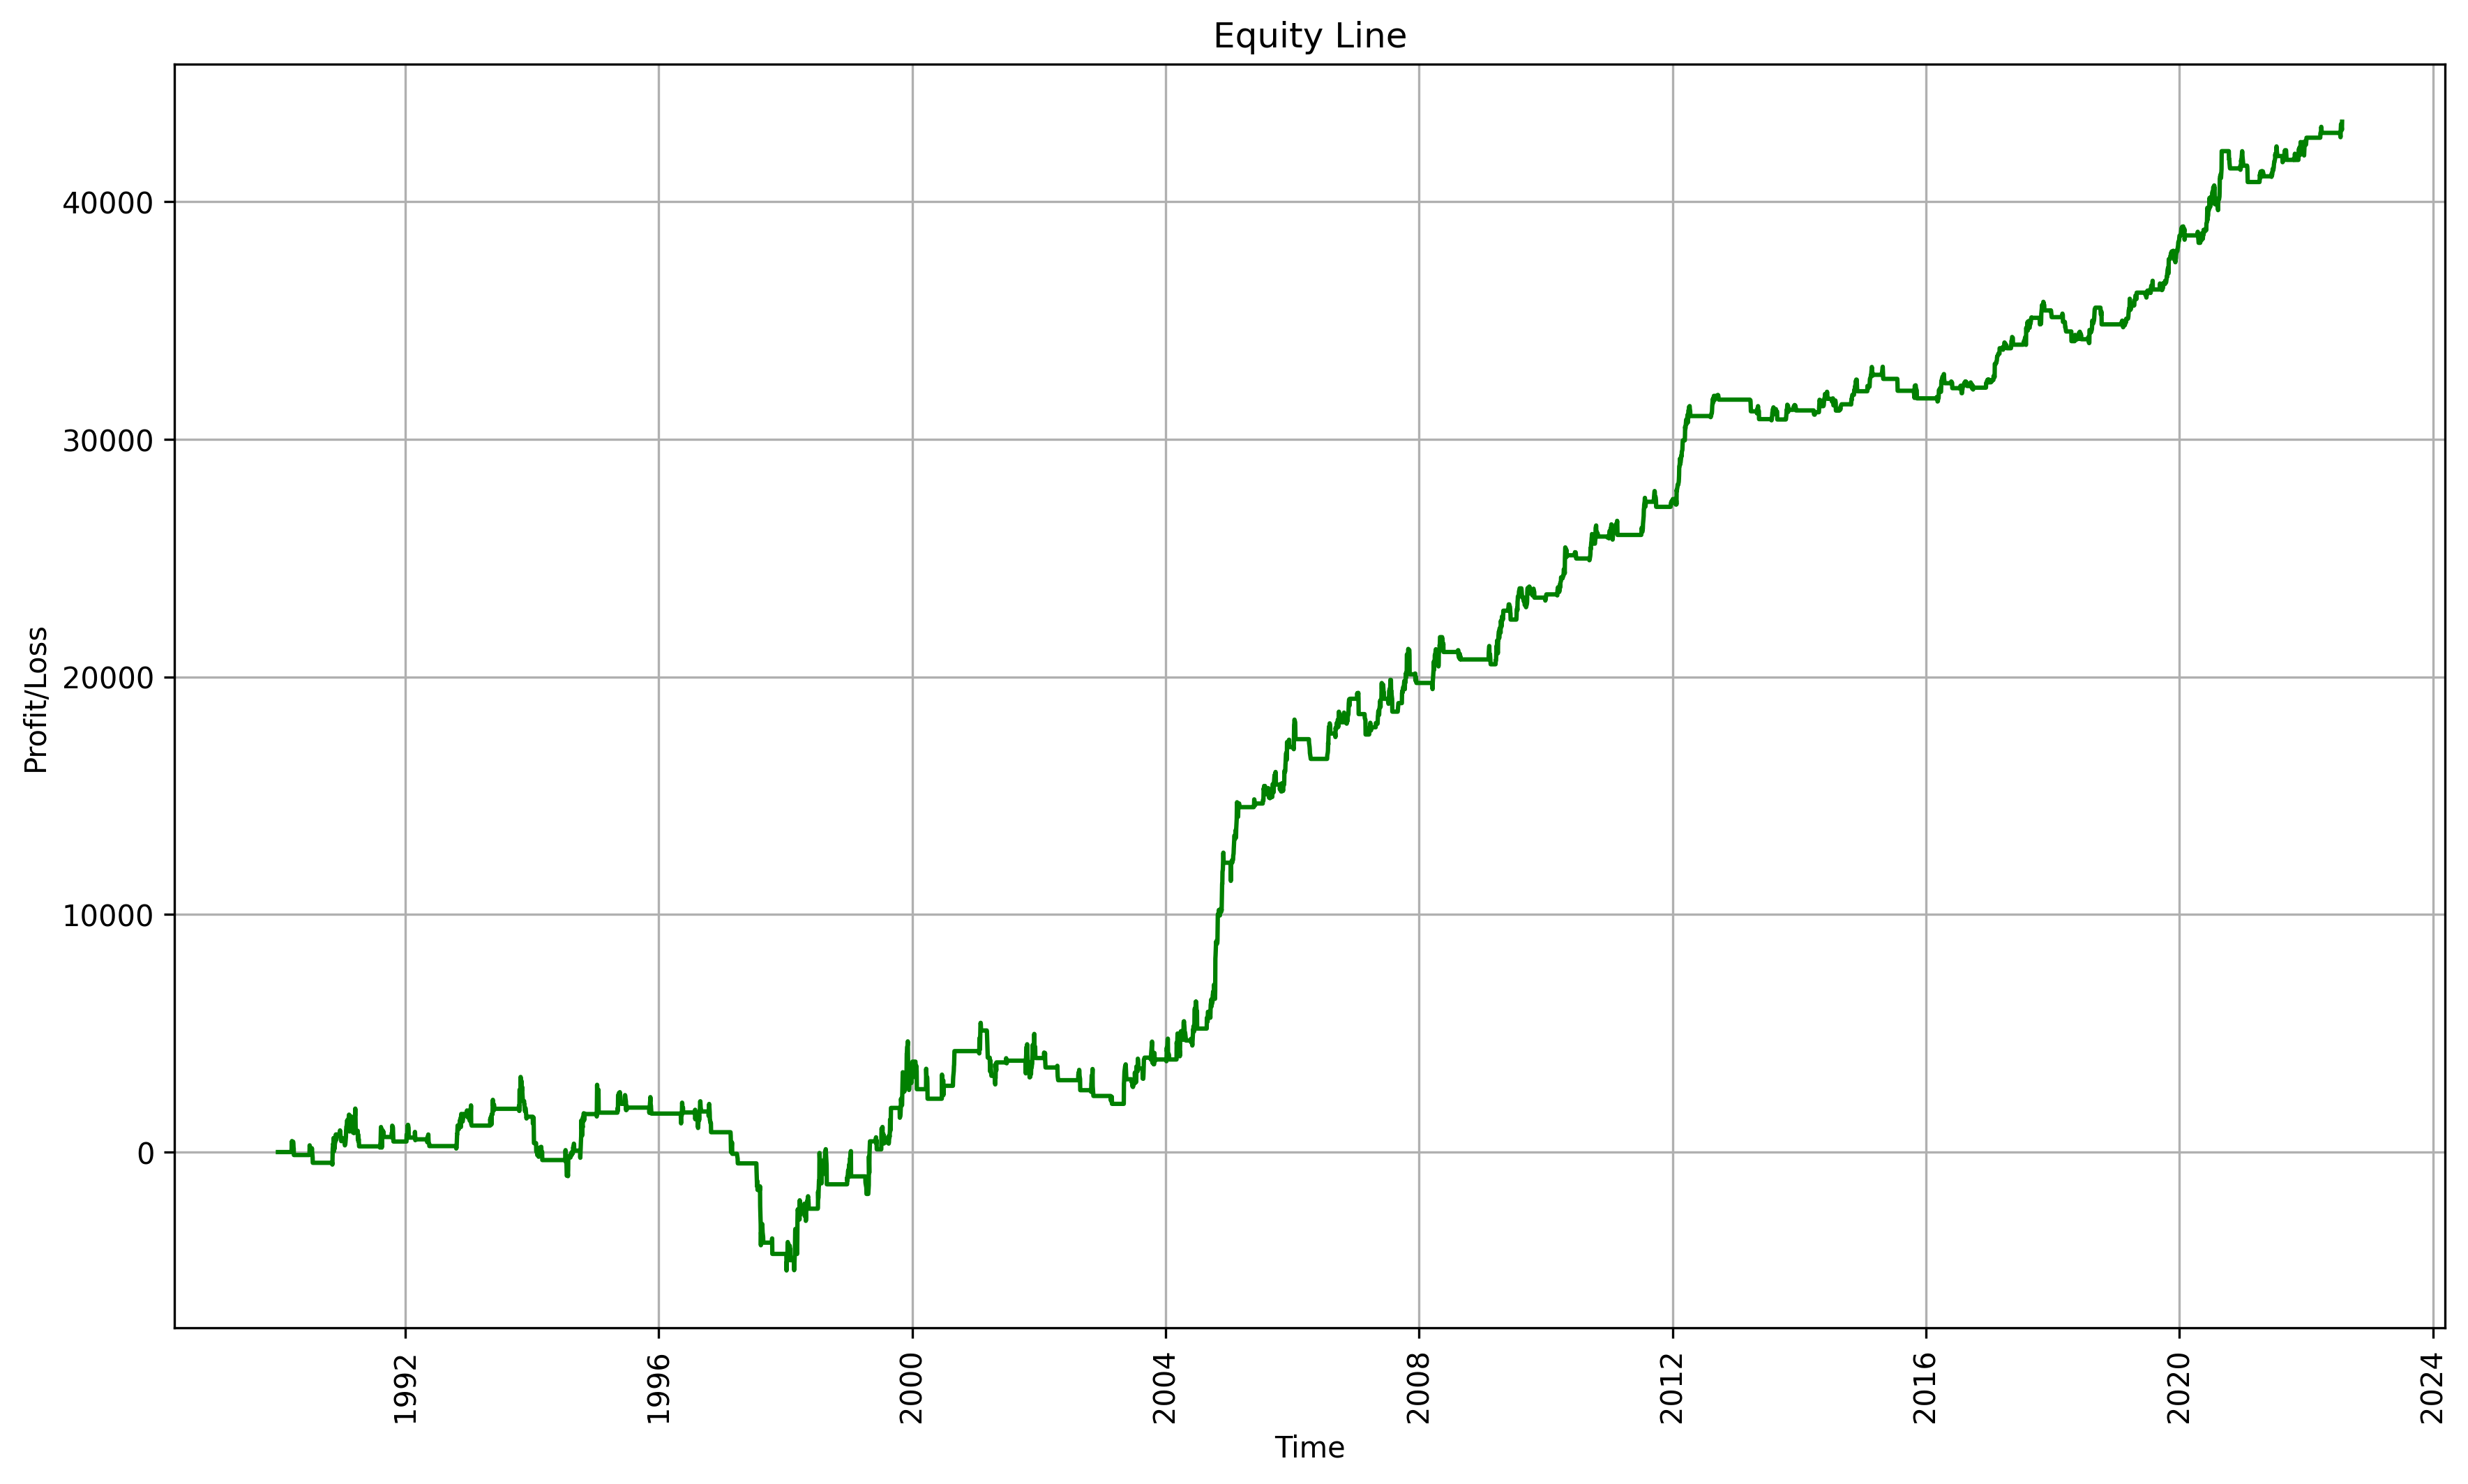

In [17]:
# Plot open equity = equity line with fluctuations during the trade  
plot_equity(trading_system.open_equity,"green");

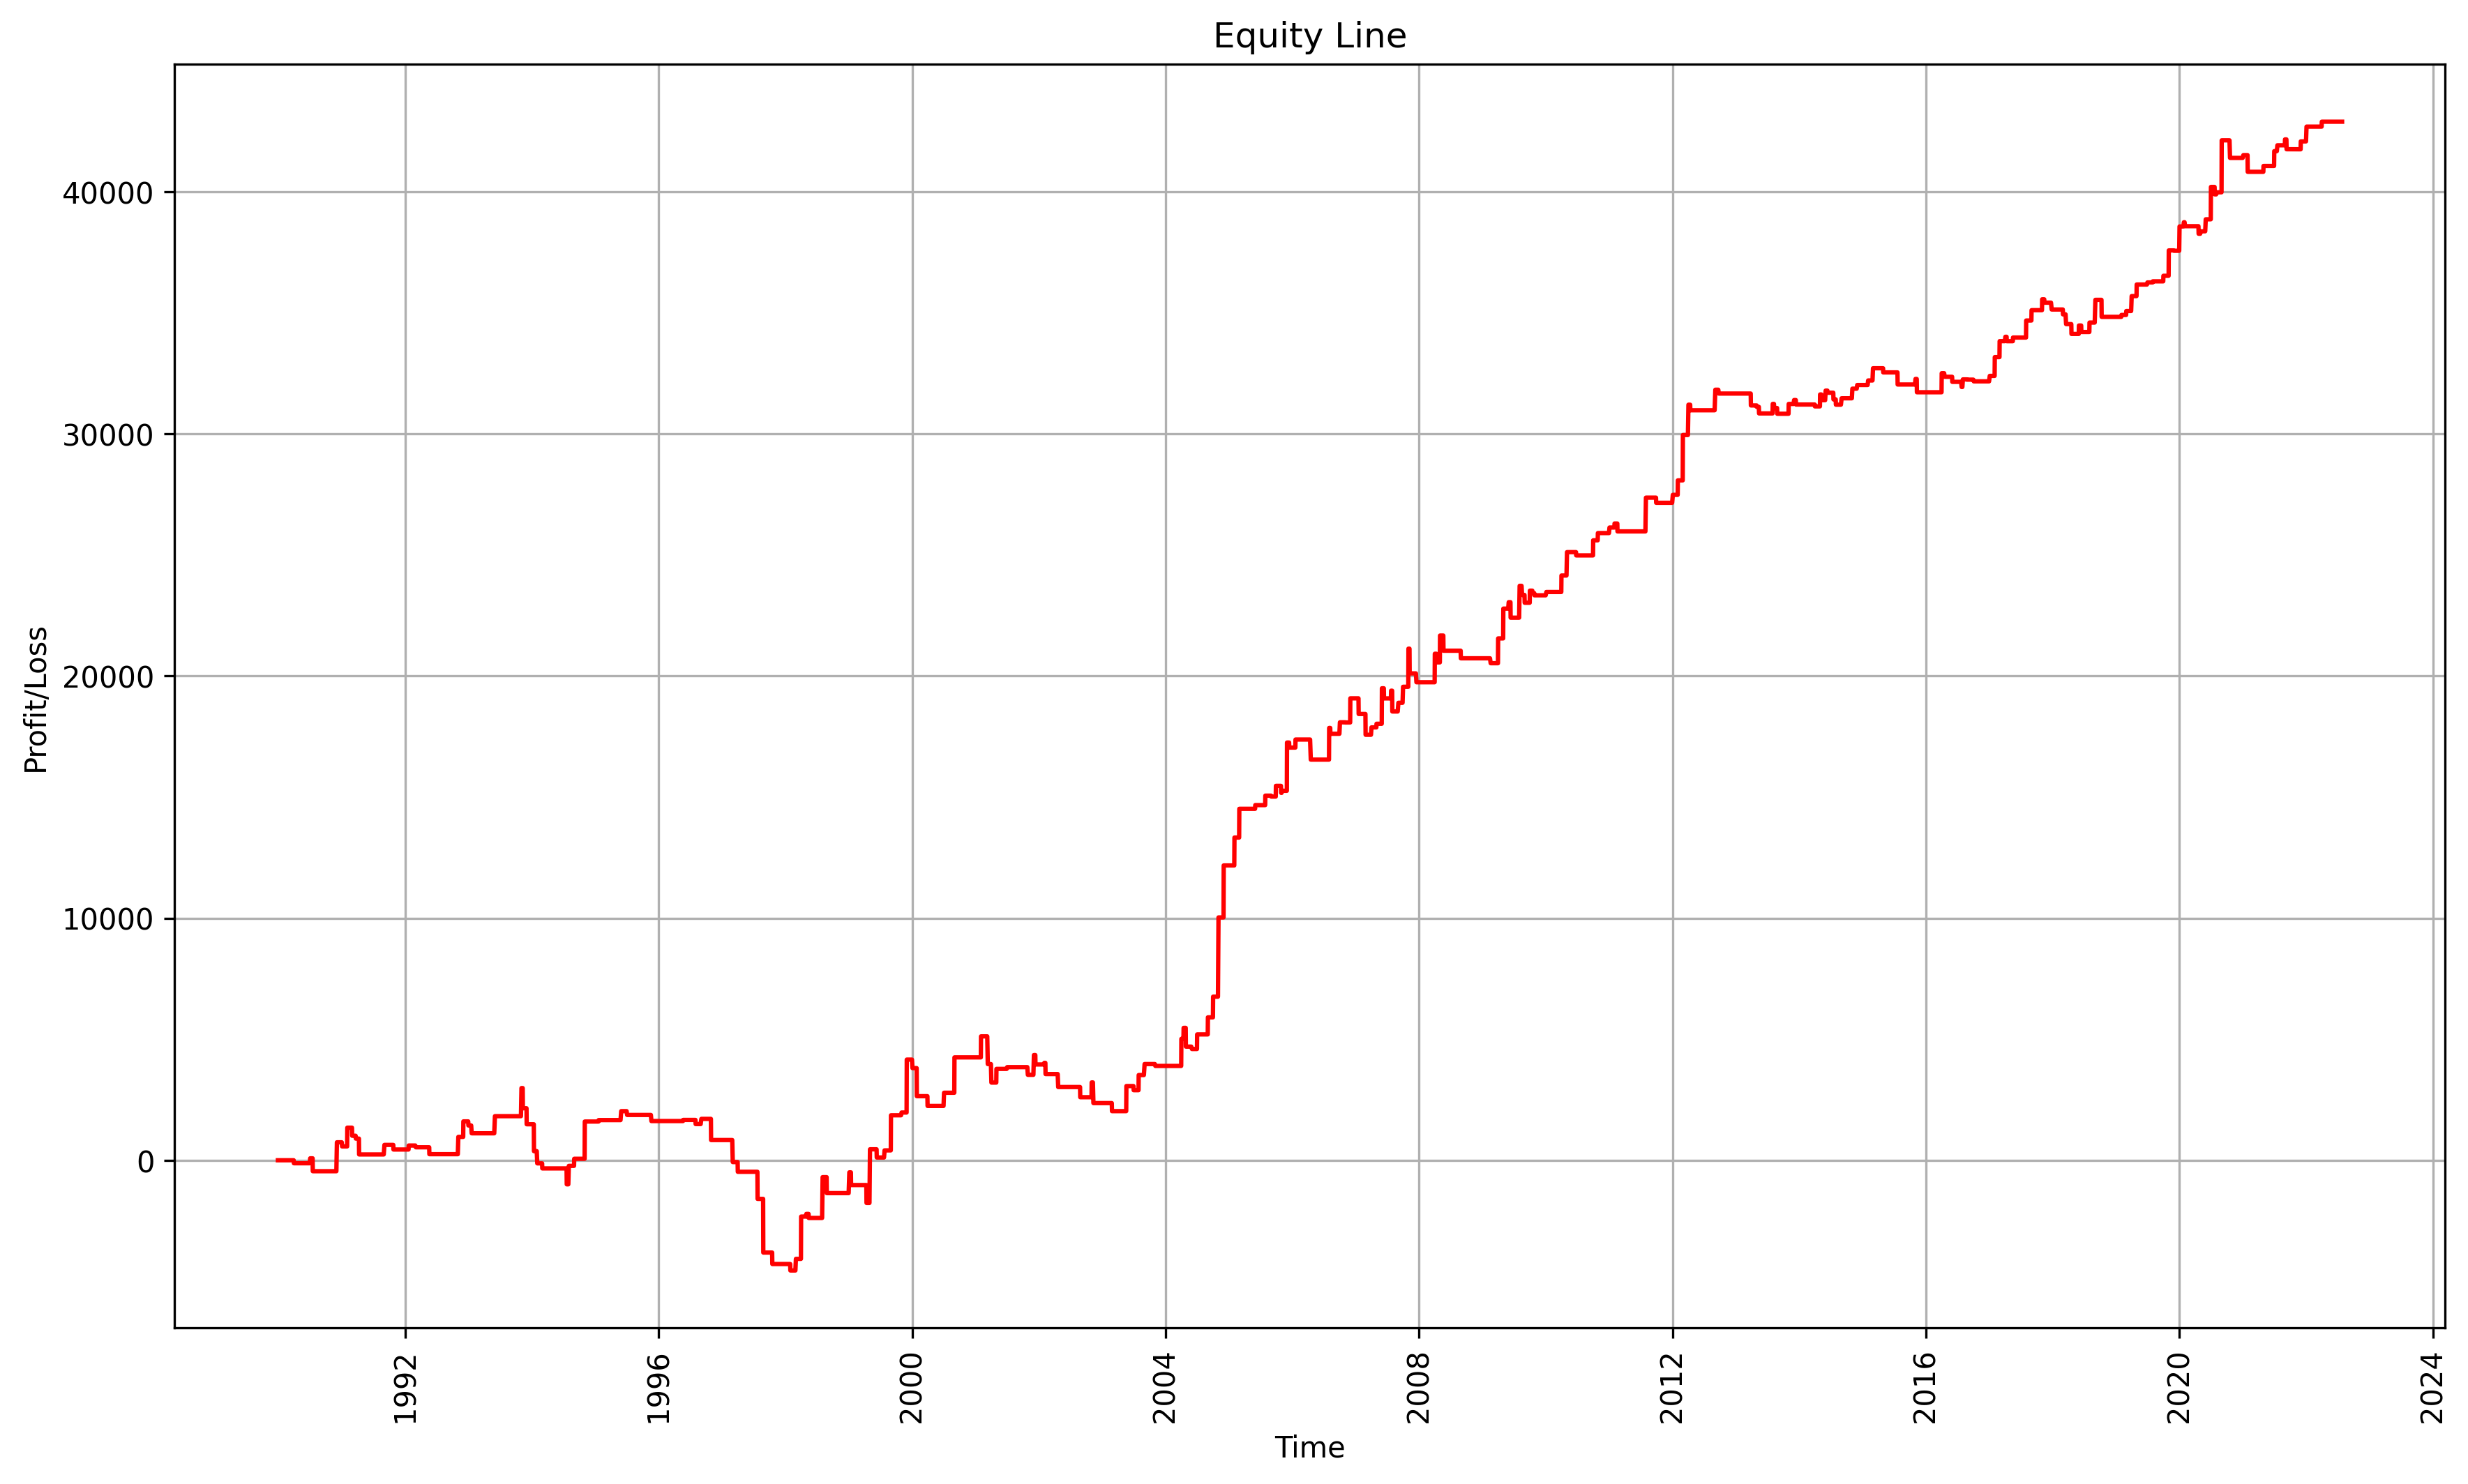

In [18]:
# Plot closed equity = equity line with not fluctuations during the trade
plot_equity(trading_system.closed_equity,"red");

In [19]:
# Drawdown = difference between the highest and lowest peak in a time interval
def drawdown(equity):
    # calculates the drawdown given an equity line
    maxvalue = equity.expanding(0).max() 
    drawdown = equity - maxvalue
    drawdown_series = pd.Series(drawdown, index = equity.index)
    return drawdown_series
# Plot Drawdown
def plot_drawdown(equity,color):
    dd = drawdown(equity)
    plt.figure(figsize = (12, 6), dpi = 300)
    plt.plot(dd, color = color)
    plt.fill_between(dd.index, 0, dd, color = color)
    plt.xlabel("Time")
    plt.ylabel("Profit/Loss")
    plt.title('Draw Down')
    plt.xticks(rotation='vertical')
    plt.grid(True)
    plt.show()
    return

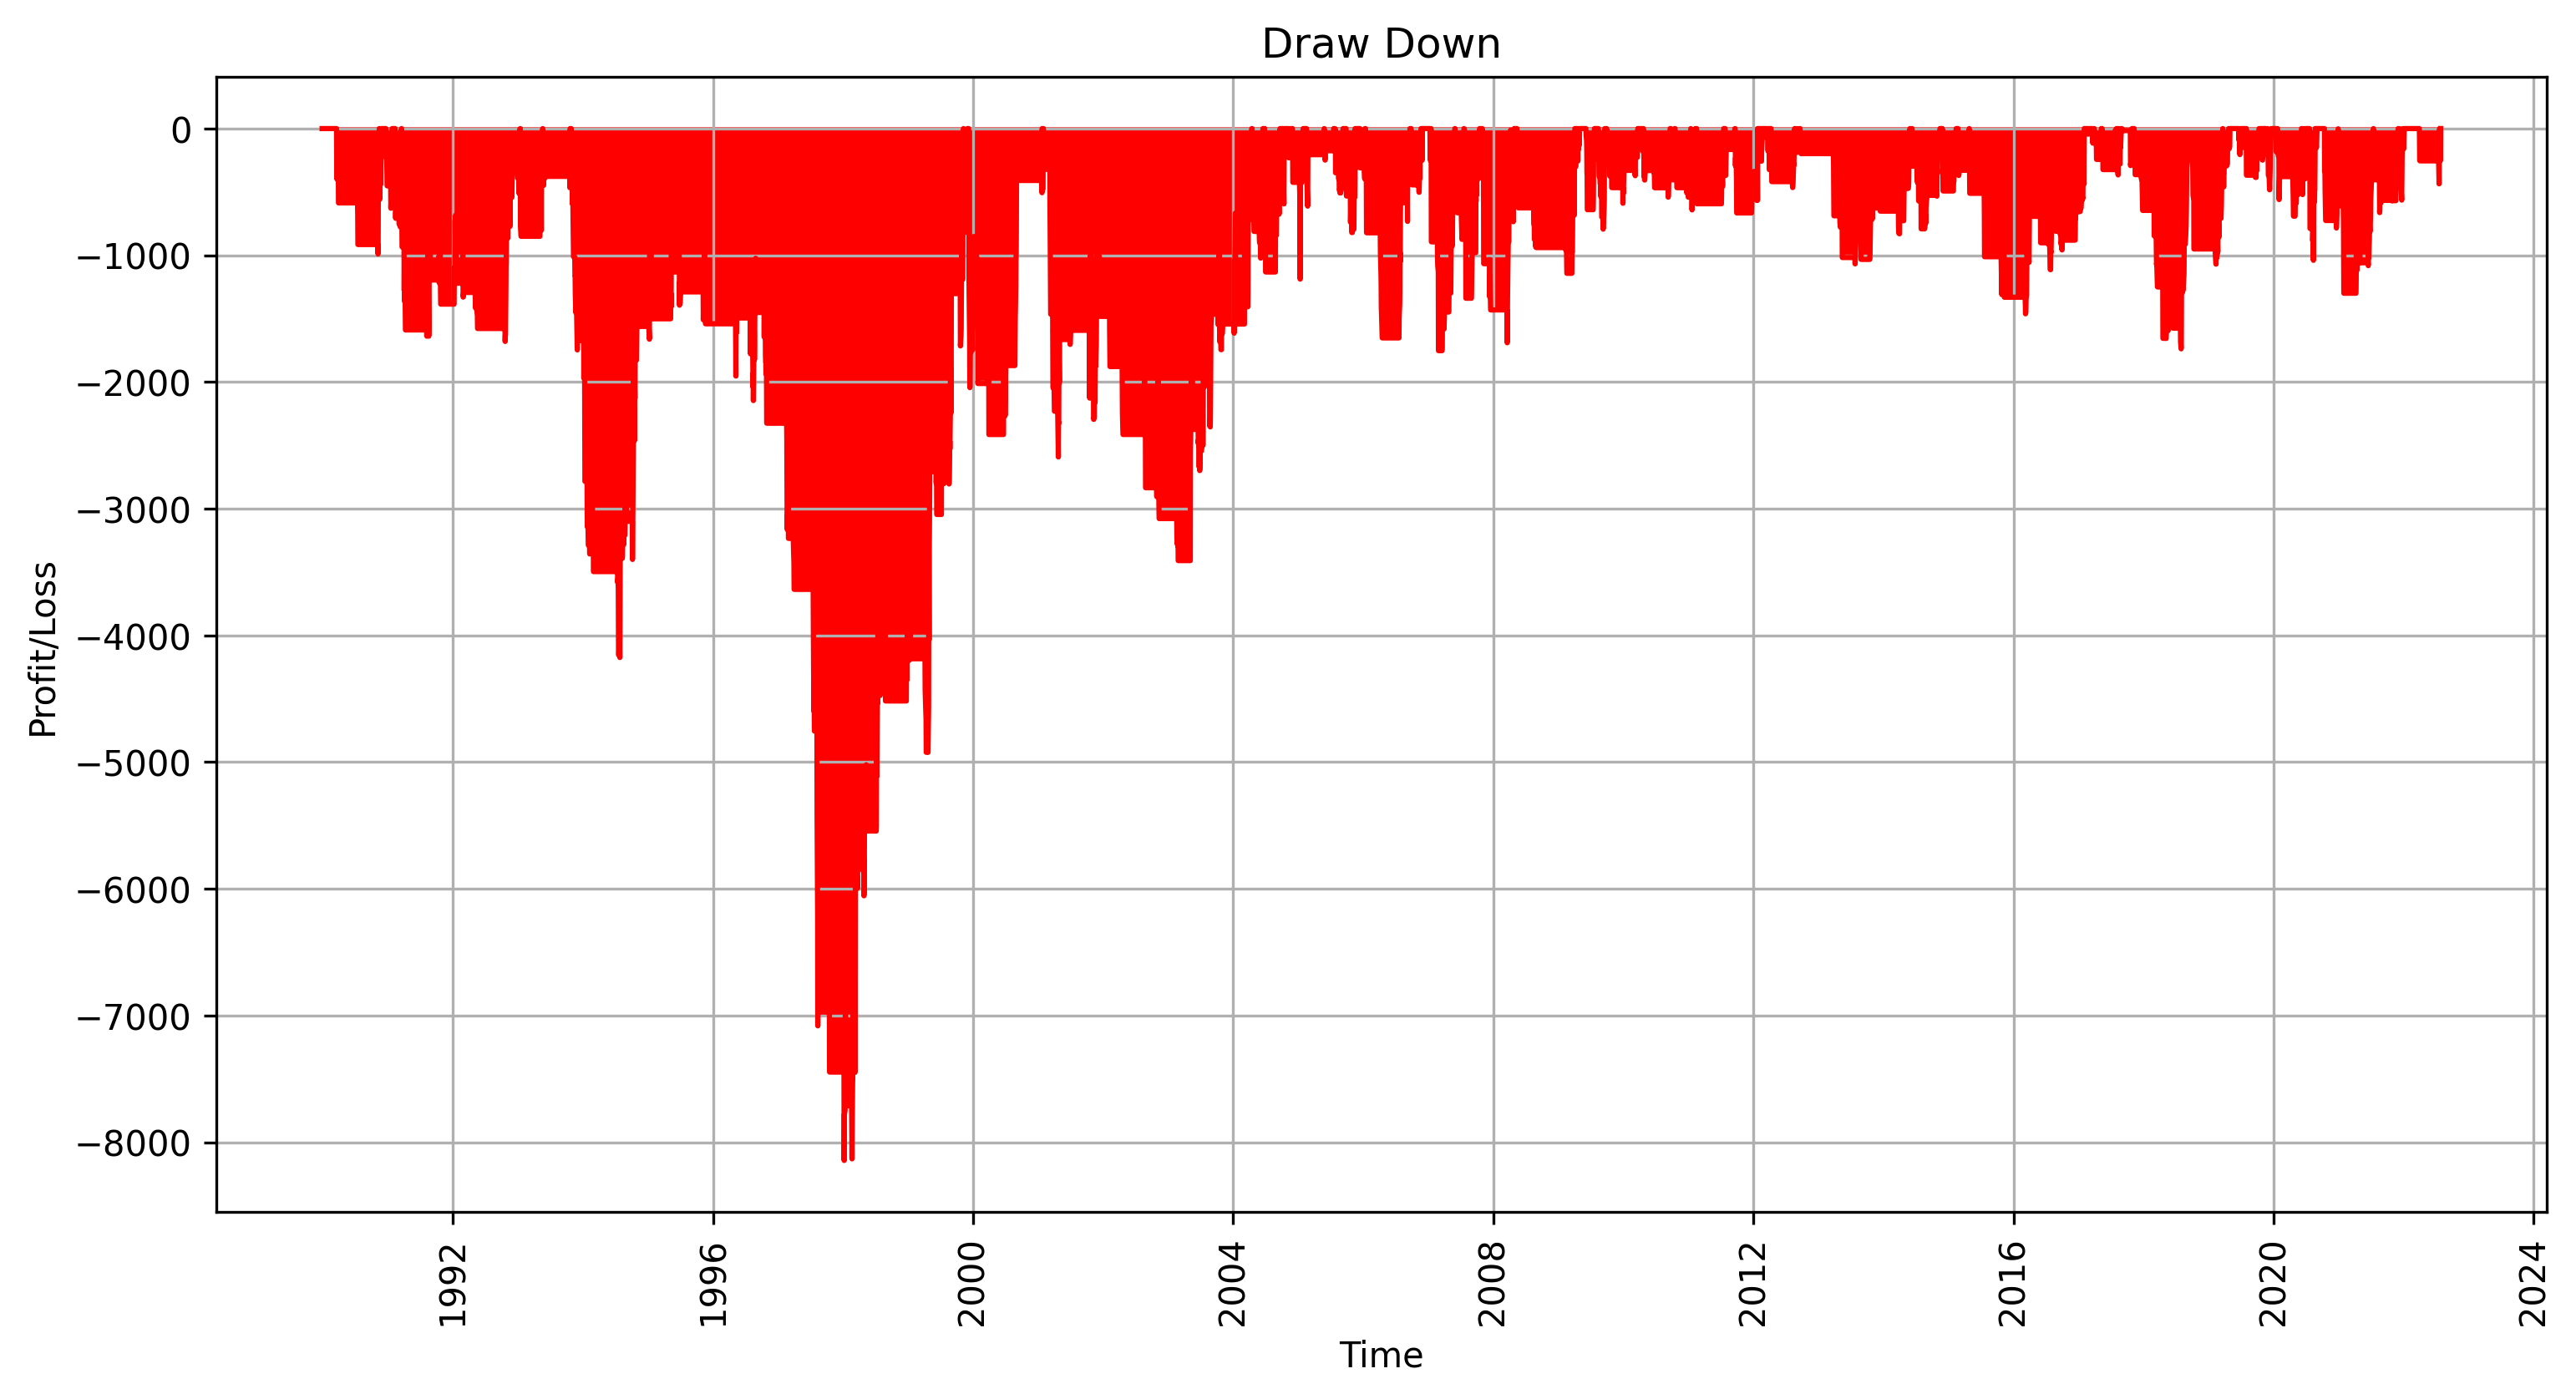

In [20]:
# Plot drawdown open equity
plot_drawdown(trading_system.open_equity,"red")

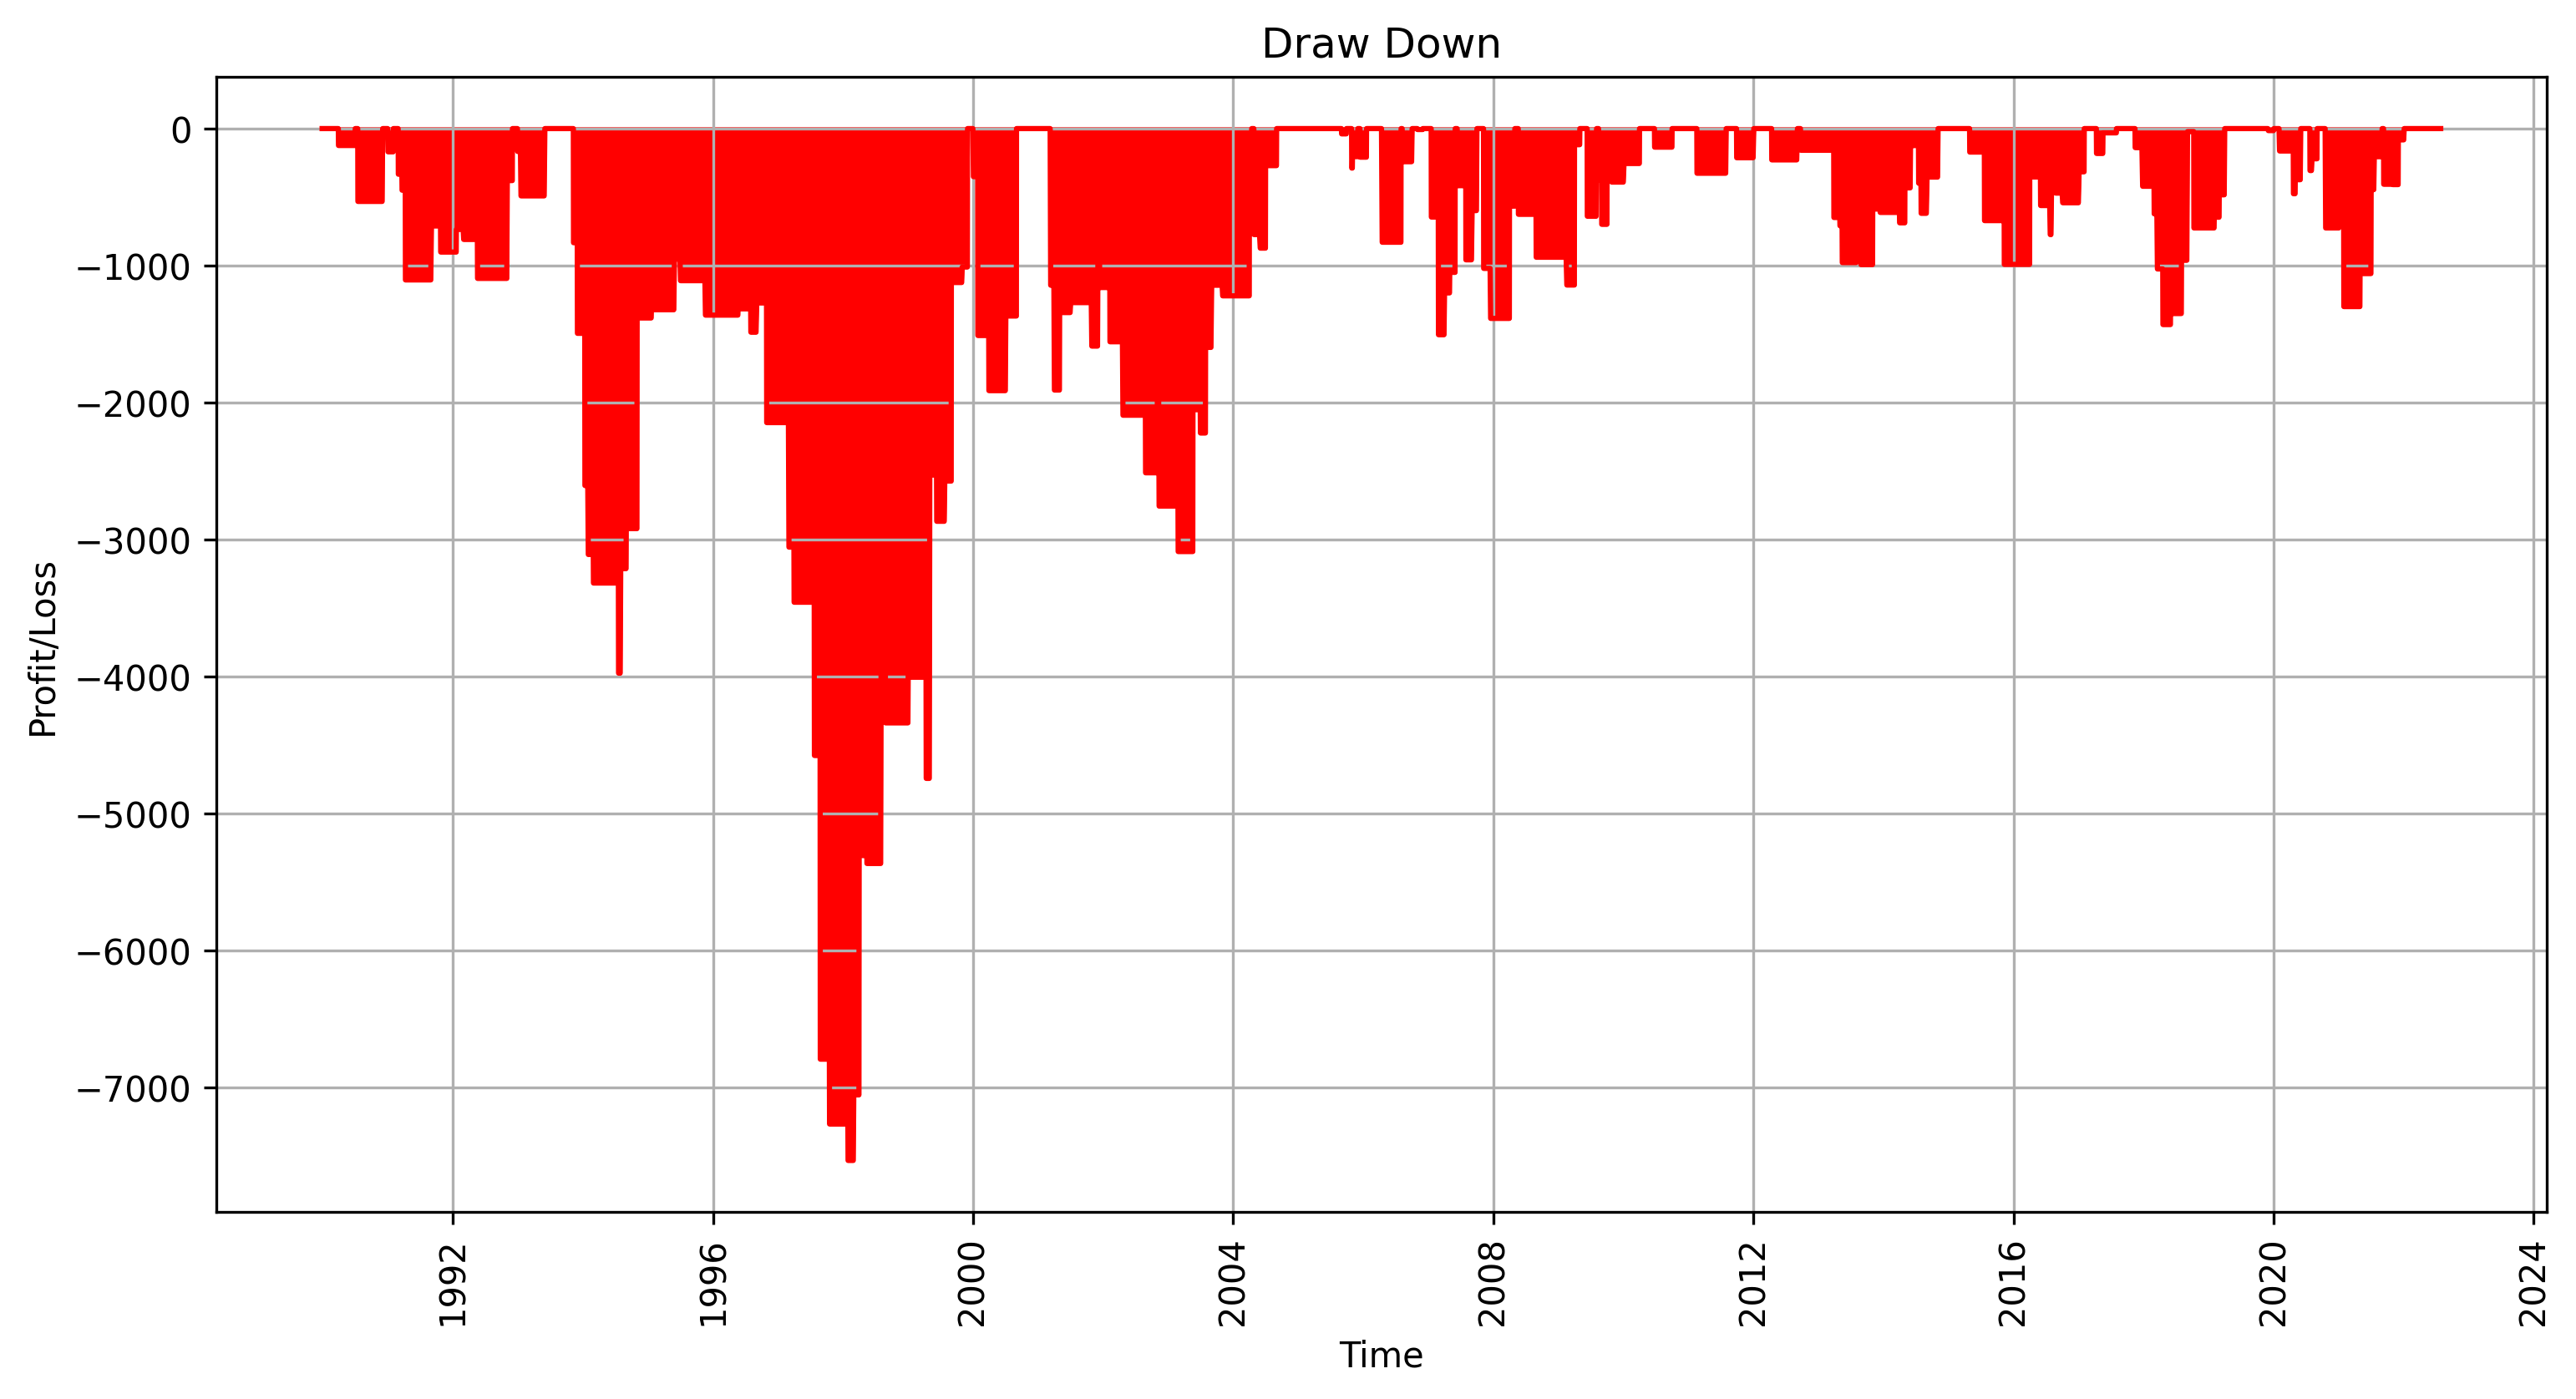

In [21]:
# Plot drawdown closed equity
plot_drawdown(trading_system.closed_equity,"red");

In [22]:
# MAX drawdown
def max_draw_down(equity):
    dd = drawdown(equity)
    return round(dd.min(),2)

print("Max Dradown: ",max_draw_down(trading_system.open_equity))

Max Dradown:  -8144.24


In [23]:
# Average drawdown
def avgdrawdown_nozero(equity):
    dd = drawdown(equity)
    return round(dd[dd < 0].mean(),2)


print("Average Dradown without metalabing: ", avgdrawdown_nozero(trading_system.open_equity))

Average Dradown without metalabing:  -1337.74


In [24]:
# Plot double equity line
def plot_double_equity(closed_equity,open_equity):
    plt.figure(figsize=(14, 8), dpi=300)
    plt.plot(open_equity, color='red', label="Open equity")
    plt.plot(closed_equity, color='green', label="Closed equity")
    plt.xlabel("Time")
    plt.ylabel("Profit/Loss")
    plt.title('Open & Closed Equity Line')
    plt.xticks(rotation='vertical')
    plt.grid(True)
    plt.legend()
    plt.show()
    return

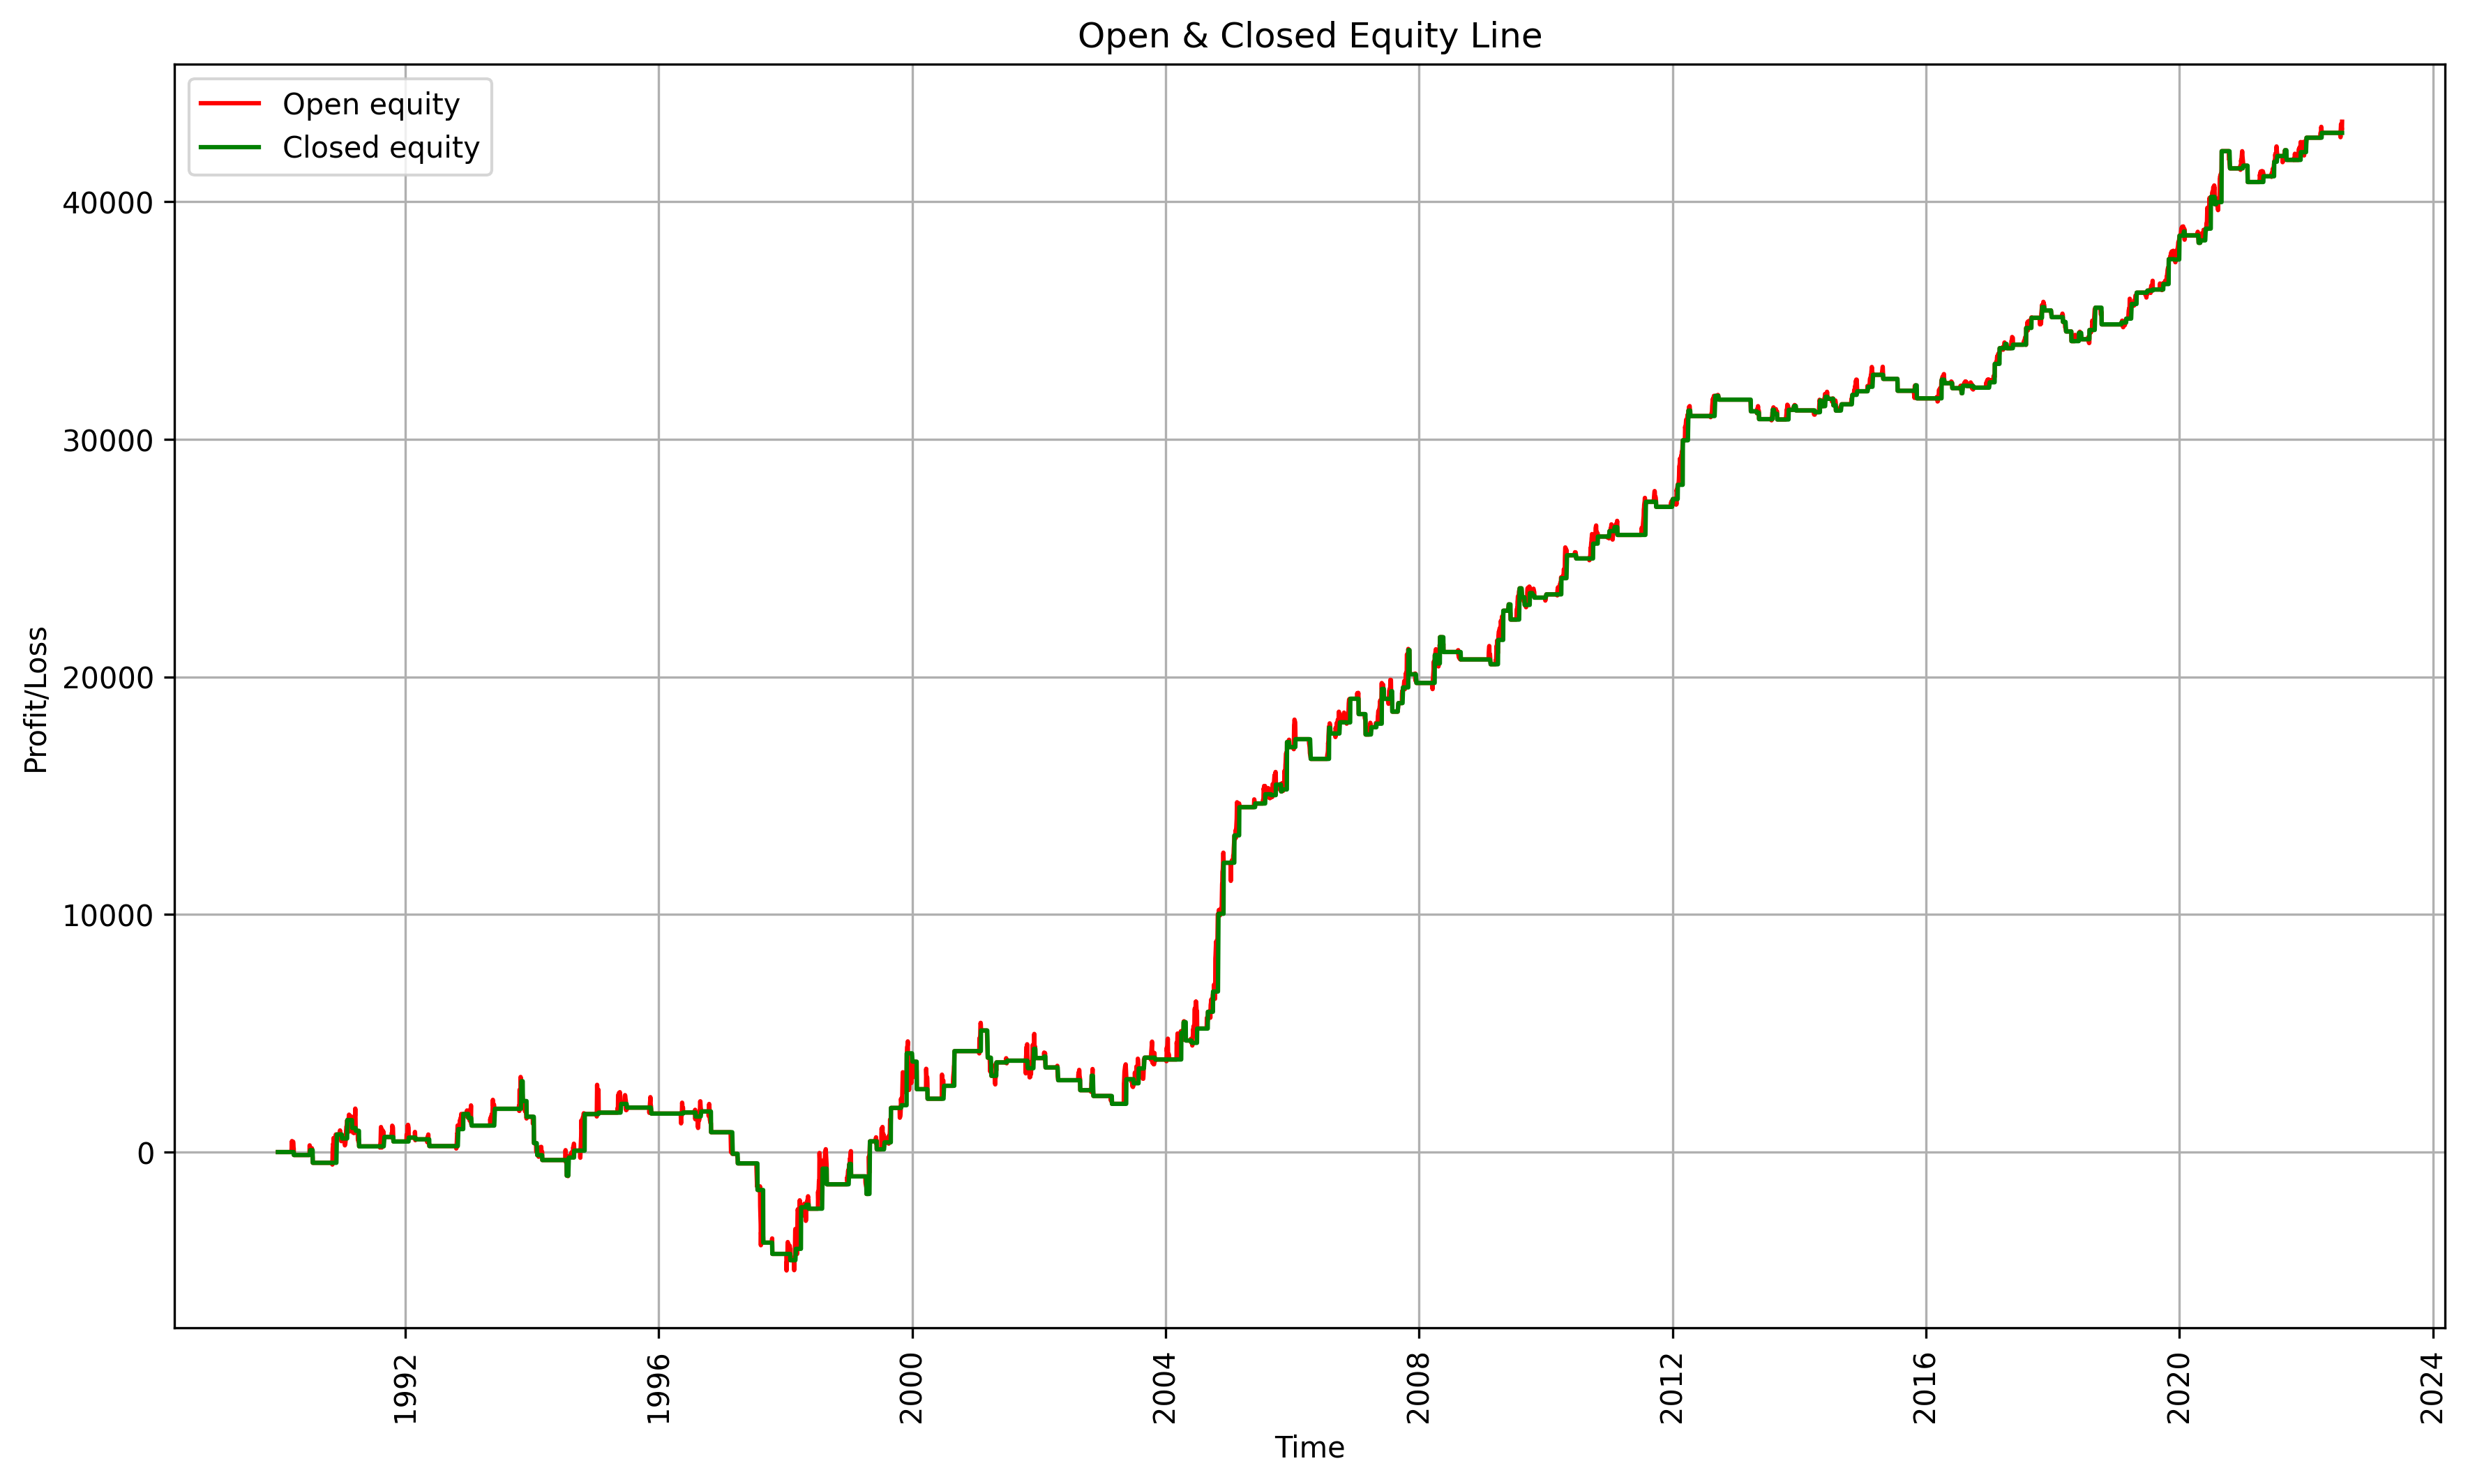

In [25]:
# Plot open e closed equity line
plot_double_equity(trading_system.closed_equity,trading_system.open_equity);

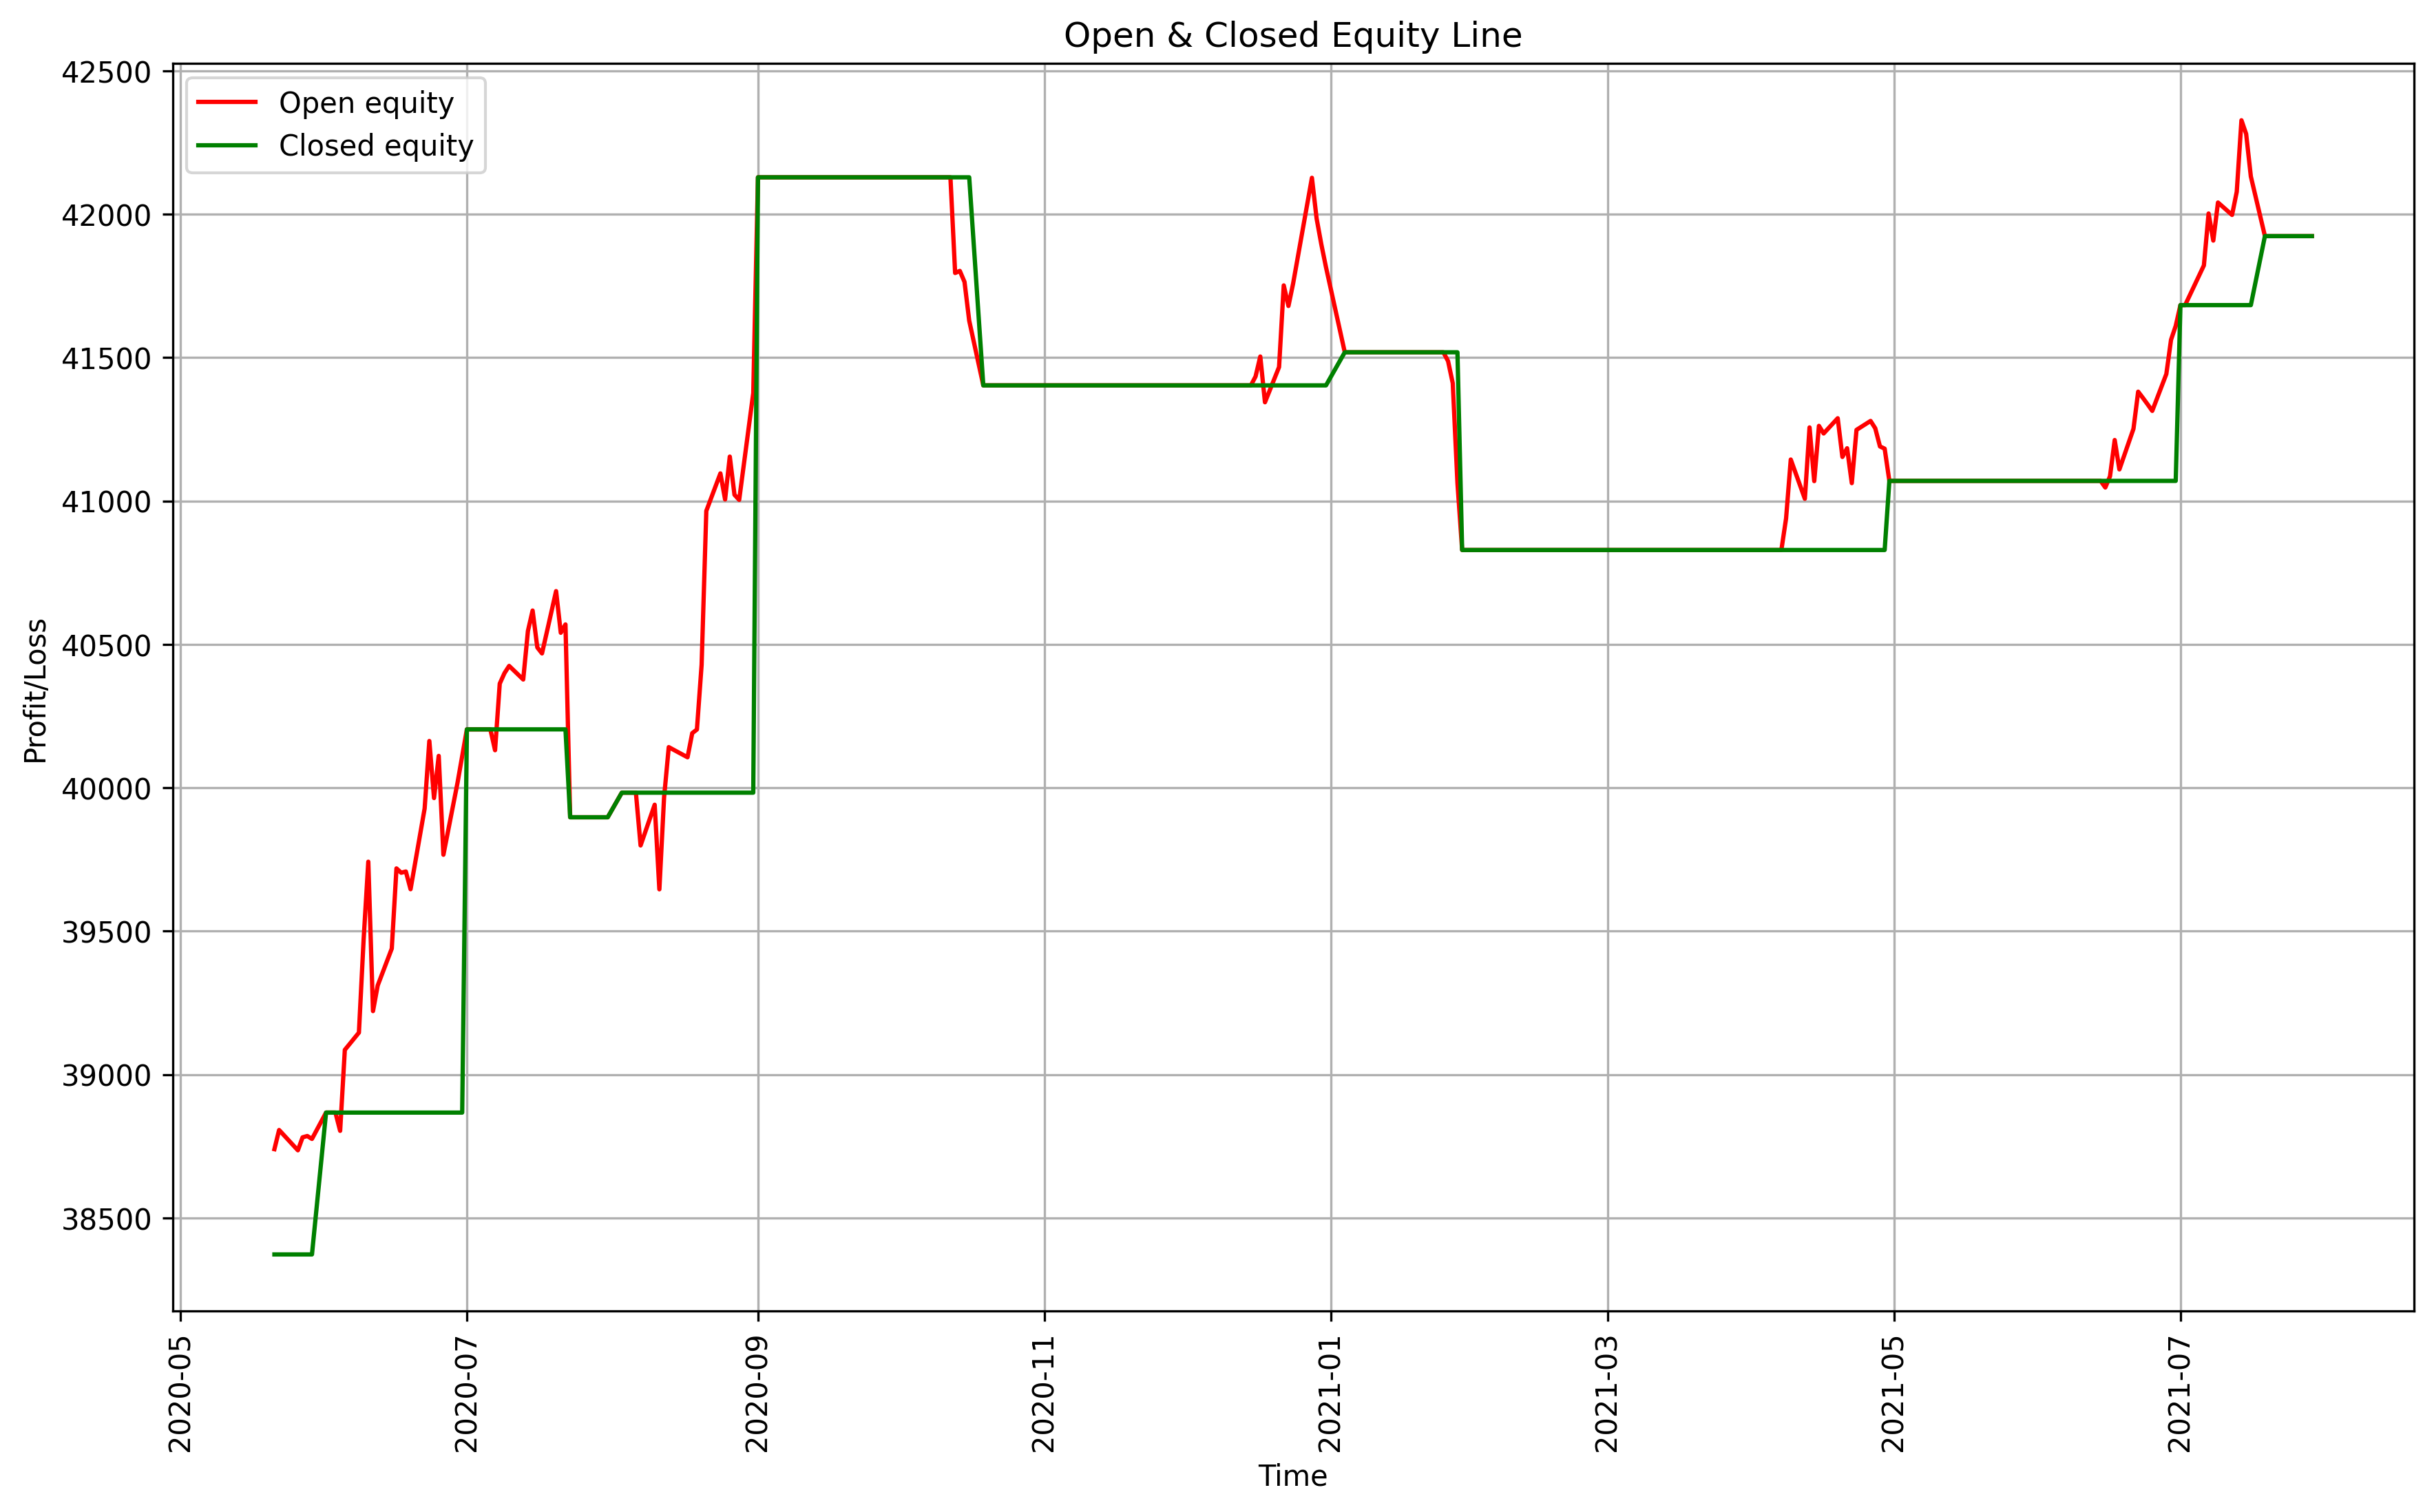

In [26]:
# Plot open e closed equity line with subset dataset
plot_double_equity(trading_system.closed_equity[-550:-250],trading_system.open_equity[-550:-250]);

In [27]:
# Plot trading system (buys and sells)
def plot_trading_system(data):
    plt.figure(figsize=(14, 8), dpi=300)
    buy_price = data['plot_entry_price']
    sell_price = data['plot_sell_price']
    data['close'].plot(label = 'CLOSE PRICES', alpha = 0.3)
    plt.scatter(data.index, buy_price, marker = '^', color = 'green', label = 'BUY', s = 200)
    plt.scatter(data.index, sell_price, marker = 'v', color = 'red', label = 'SELL', s = 200)
    plt.title('APPLE Dochian channel STRATEGY TRADING SIGNALS')
    plt.legend(loc = 'upper left')
    plt.show()

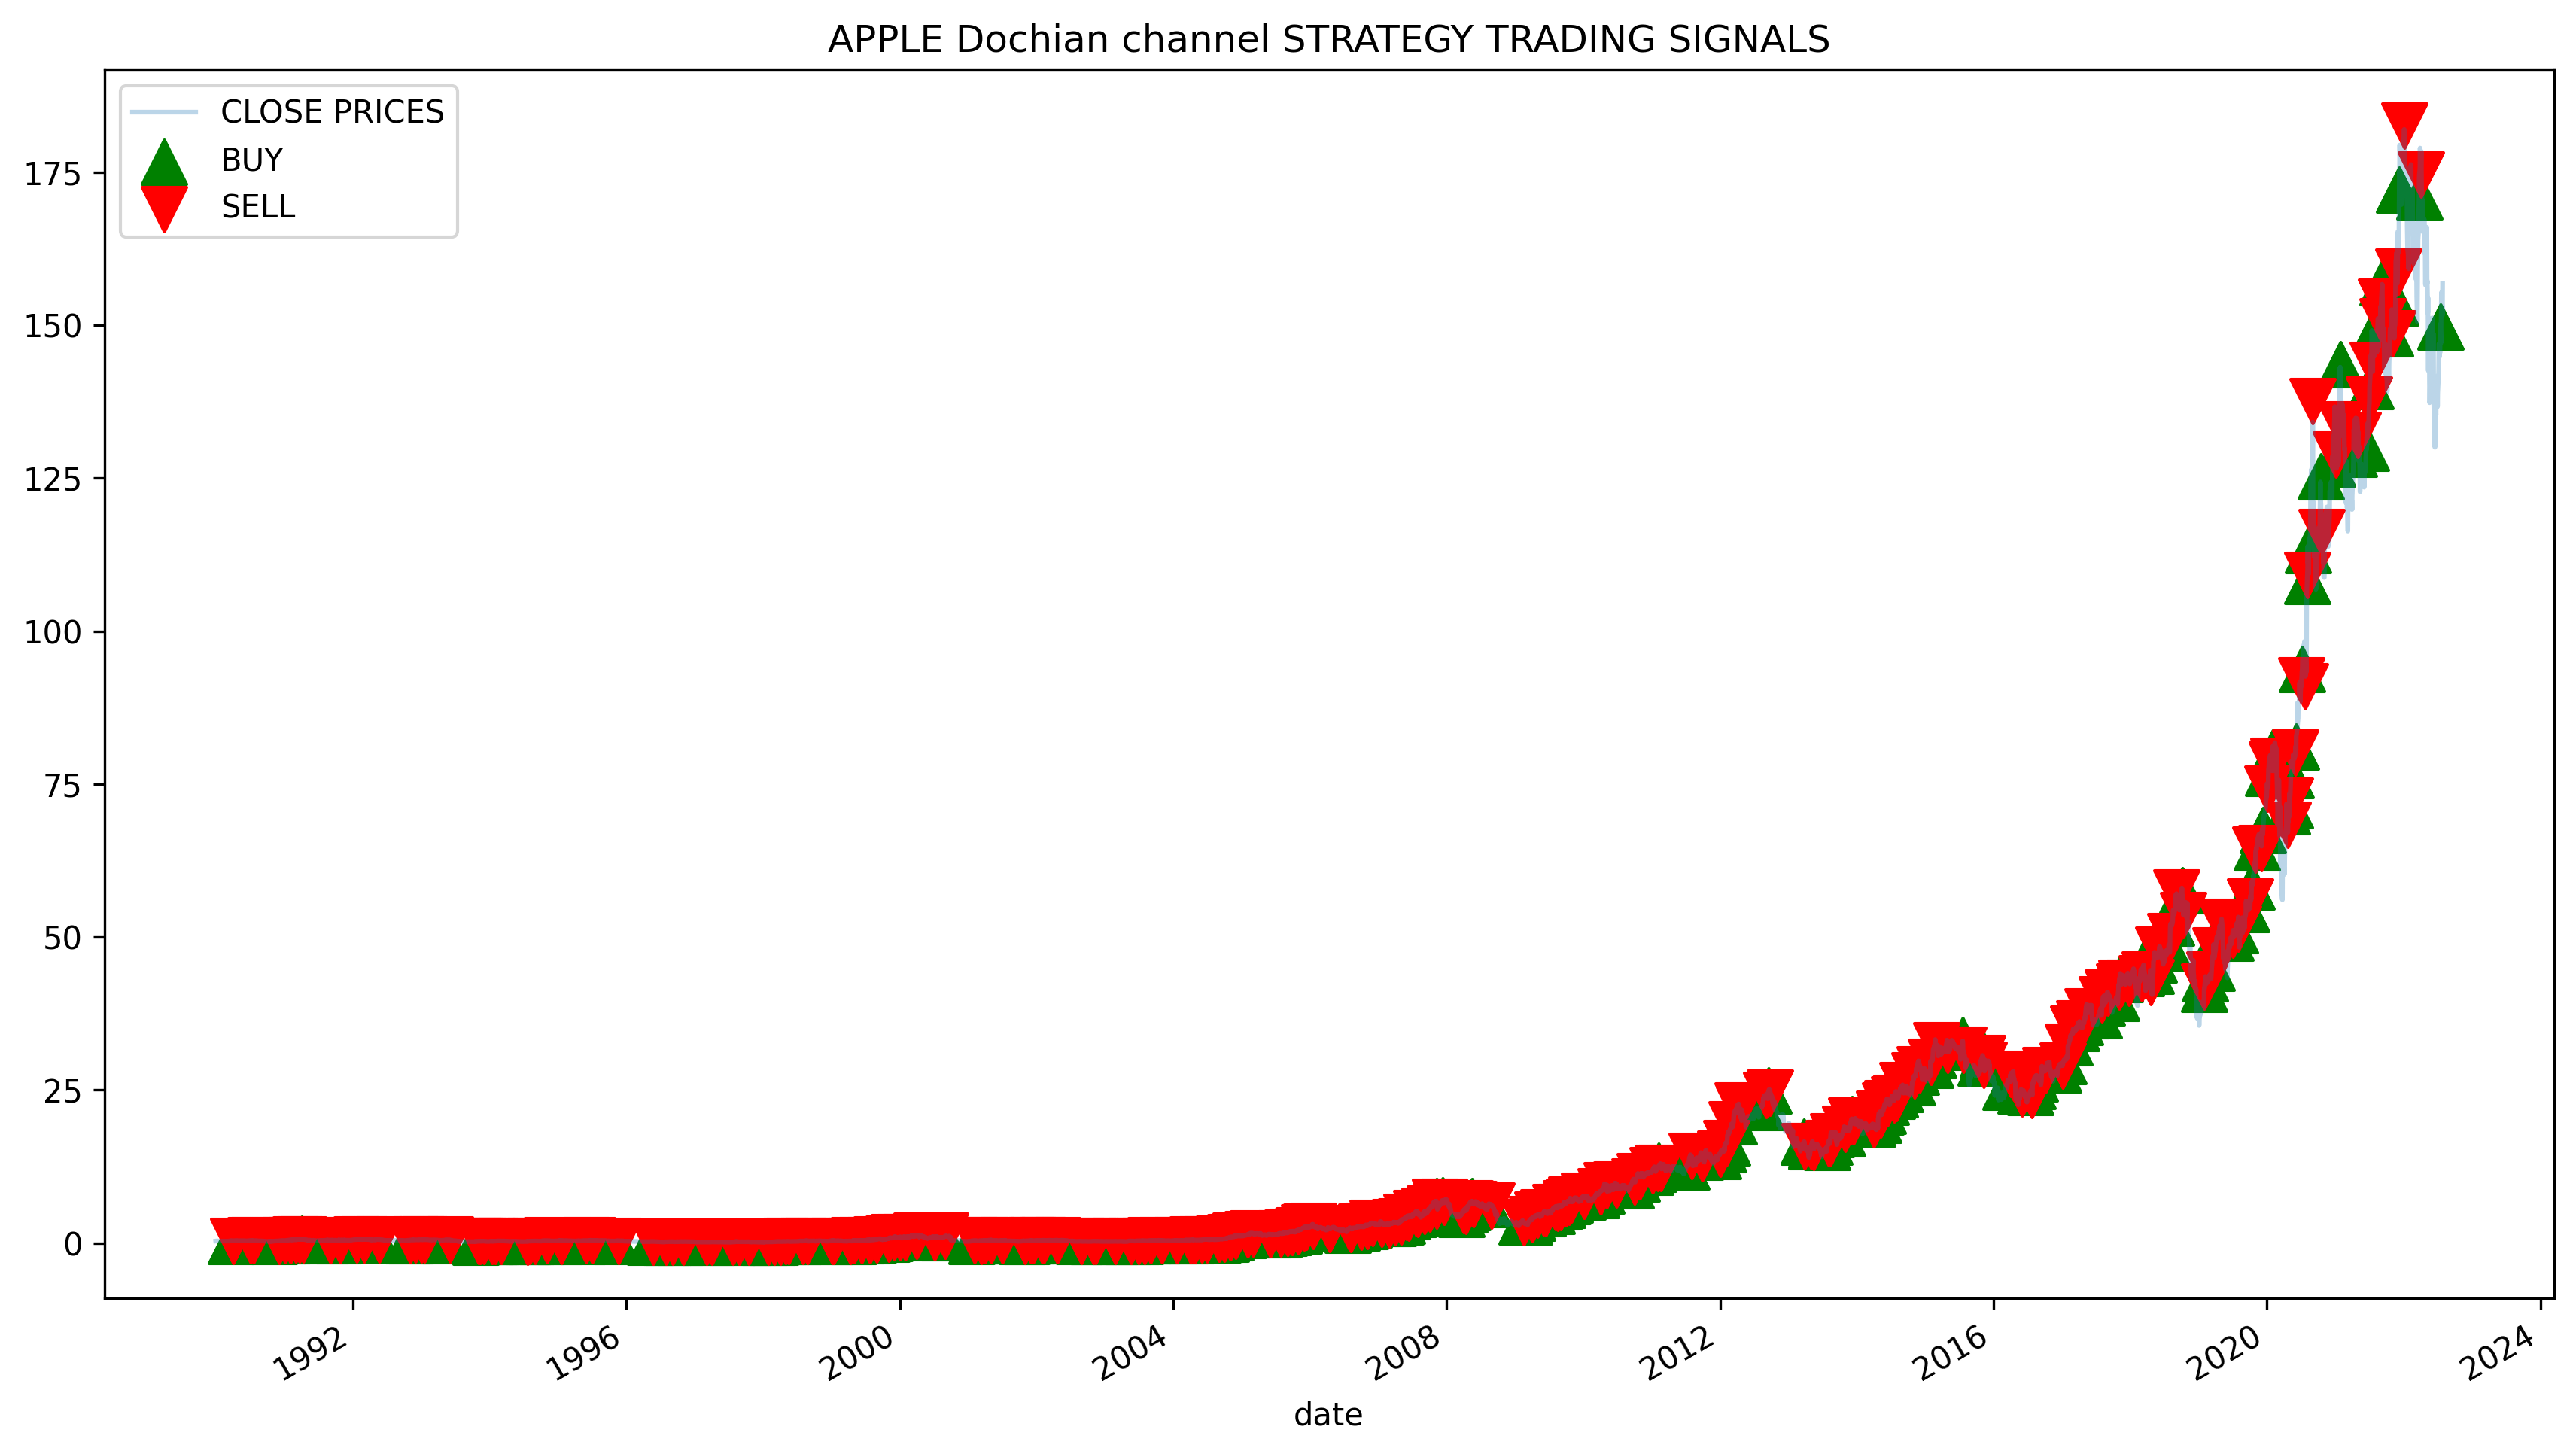

In [28]:
# plot trading system
plot_trading_system(trading_system) 

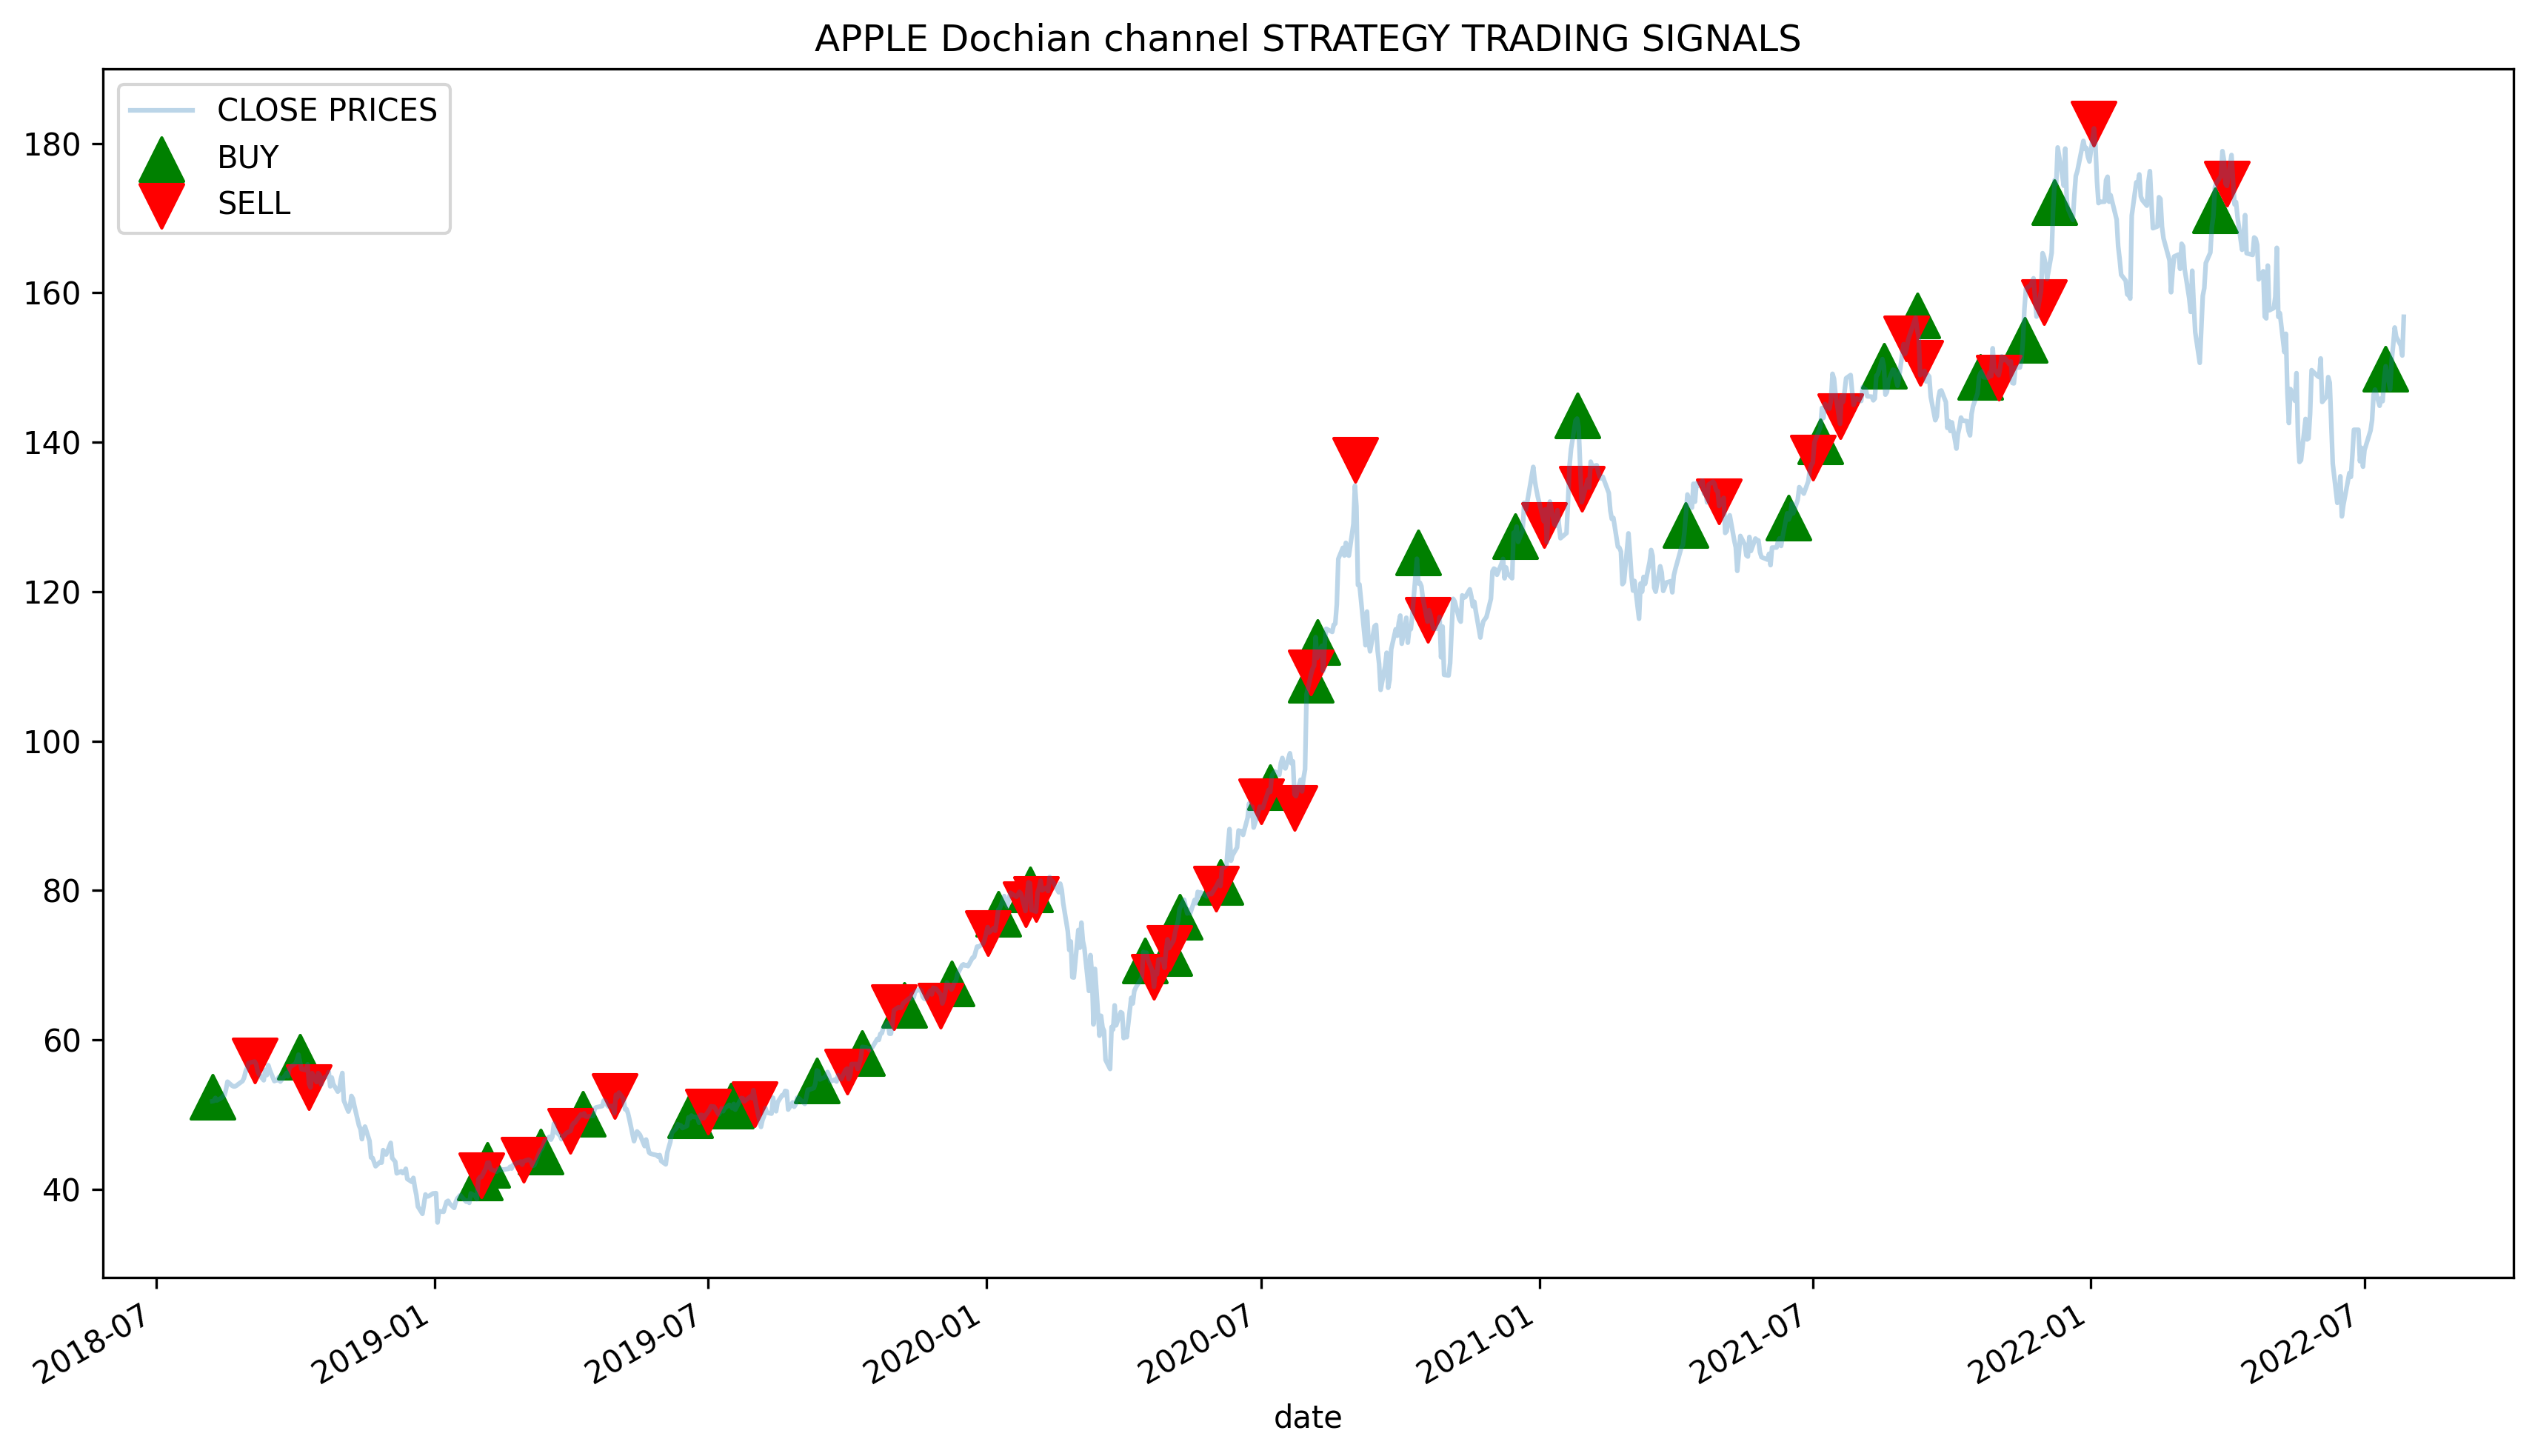

In [29]:
# plot trading system with subset dataset
plot_trading_system(trading_system.iloc[len(data)-1000:,:])